In [1]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import requests
import asinfo
import clusterbycolumn as cbc

import matplotlib.dates as dates
from datetime import datetime as dt

In [2]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [5]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

In [6]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , stall_duration_total
                  
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
           
           and successes = 1
           and failures = 0
           
           and stall_events <> 0
           
           order by dtime DESC
        '''

In [7]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [8]:
df.head()

,probe,dtime,video_address,stall_duration_total
0,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282
1,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282
2,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282
3,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282
4,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282


In [9]:
num_probes = len(set(df['probe']))

In [10]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [11]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [12]:
df.head()

,probe,dtime,video_address,stall_duration_total
0,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
1,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
2,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
3,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
4,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282


In [13]:
df.tail()

,probe,dtime,video_address,stall_duration_total
1868,samsbox10,2014-08-21 15:00:00,2a00:1450:4009:36::e,55735572
1869,samsbox07,2014-08-21 14:00:00,2a00:1450:4009:36::e,55867638
1870,samsbox10,2014-08-21 14:00:00,2a00:1450:4009:36::e,56905588
1871,samsbox07,2014-08-21 13:00:00,2a00:1450:4009:36::e,56793754
1872,samsbox10,2014-08-21 13:00:00,2a00:1450:4009:36::e,56835570


In [14]:
df.count()

probe                   1873
dtime                   1873
video_address           1873
stall_duration_total    1873
dtype: int64

In [15]:
def filter_by_ip(df, column):
  """reads a DataFrame, calls fbi.filter_v{4,6} to get DataFrames with rows
     containing only v4, v6 endpoints. Returns the two DataFrame as a tuple"""

  dfv6 = fbi.filter_v6(df, column)
  dfv4 = fbi.filter_v4(df, column)
  return dfv4, dfv6

In [16]:
dfv4, dfv6 = filter_by_ip(df, column = 'video_address')

In [17]:
dfv4.head()

,probe,dtime,video_address,stall_duration_total
0,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
1,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
2,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
3,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
4,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282


In [18]:
dfv6.head()

,probe,dtime,video_address,stall_duration_total
5,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852
6,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852
7,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852
8,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852
9,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852


In [19]:
dfv4['name'] = dfv4['probe'].apply(lambda name: "#%02d"%int(name[7:]))
dfv6['name'] = dfv6['probe'].apply(lambda name: "#%02d"%int(name[7:]))
del dfv4['probe']; del dfv6['probe']

In [20]:
dfv6.count()

dtime                   1522
video_address           1522
stall_duration_total    1522
name                    1522
dtype: int64

In [21]:
dfv4.count()

dtime                   351
video_address           351
stall_duration_total    351
name                    351
dtype: int64

In [22]:
df = pd.merge(dfv4, dfv6, on=["name", "dtime"], how='outer')

In [23]:
df.count()

dtime                     1715
video_address_x            351
stall_duration_total_x     351
name                      1715
video_address_y           1522
stall_duration_total_y    1522
dtype: int64

In [24]:
df.rename(columns={  'video_address_x'             : 'video_ep_4'
                   , 'stall_duration_total_x'      : 'stall_total_4'             
                   , 'video_address_y'             : 'video_ep_6'
                   , 'stall_duration_total_y'      : 'stall_total_6'                                
                  } ,  inplace=True)

In [25]:
df = df.fillna(0)

In [26]:
df.head()

,dtime,video_ep_4,stall_total_4,name,video_ep_6,stall_total_6
0,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0
1,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0
2,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0
3,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0
4,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0


In [27]:
df['46_stall_total']  = df.stall_total_4.map(str) + ',' + df.stall_total_6.map(str)

### Calculate Absolute Difference

In [28]:
def get_difference(v4v6_stall_total):
    
    v4, v6 = v4v6_stall_total.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_stall_total)
    
    difference = (v4 - v6)
    difference = difference / 1000000            
    return float('%0.2f'%difference)

df['st_a'] = df['46_stall_total'].apply(get_difference)

In [29]:
del df['video_ep_4']; del df['video_ep_6'];
del df['46_stall_total']

In [30]:
def round_time_to_day(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(hour=0, minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d')
    return dtime

df['dtime'] = df['dtime'].apply(round_time_to_day)

In [31]:
df.head()

,dtime,stall_total_4,name,stall_total_6,st_a
0,2017-04-26,31840282.0,#88,0.0,31.84
1,2017-04-26,31840282.0,#88,0.0,31.84
2,2017-04-26,31840282.0,#88,0.0,31.84
3,2017-04-26,31840282.0,#88,0.0,31.84
4,2017-04-26,31840282.0,#88,0.0,31.84


In [32]:
targets = ['st_a', 'stall_total_4', 'stall_total_6']

def get_stall_duration_across_probes(df):
    dfgroupby  = cbc.group(df, column=['dtime'])
    df_agg     = cbc.aggregate(dfgroupby, targets, ['median'])
    df_merged  = cbc.merge(df, df_agg, column=['dtime'])
    df         = df_merged.drop(targets + ['name'], axis=1)
    df         = df.drop_duplicates()
    df.columns = ['dtime'] + targets
    return df

df = get_stall_duration_across_probes(df)

In [33]:
df['dtime'] = df['dtime'].apply(lambda d: dt.strptime(d, '%Y-%m-%d'))
df.sort_values(by = 'dtime', inplace = True)

In [34]:
df['stall_total_4'] = df['stall_total_4'].div(1000000)
df['stall_total_6'] = df['stall_total_6'].div(1000000)

In [35]:
df.head()

,dtime,st_a,stall_total_4,stall_total_6
1695,2014-08-21,-56.810,0.0,56.810840
1649,2014-08-22,-56.795,0.0,56.798294
1603,2014-08-23,-56.820,0.0,56.819890
1557,2014-08-24,-55.930,0.0,55.930065
1511,2014-08-25,-55.780,0.0,55.781202


### hardcoded dates

In [36]:
from dateutil import rrule
a=dt.strptime(str('2014-08-01'), '%Y-%m-%d')
b=dt.strptime(str('2017-07-01'), '%Y-%m-%d')
dateranges = rrule.rrule(rrule.DAILY, dtstart=a).between(a, b, inc=True)

In [37]:
df_ = pd.DataFrame(dateranges, columns=['dtime']).sort_values(by = 'dtime').reset_index(drop = True)
df = pd.merge(df_, df, how='outer')

In [38]:
df.count()

dtime            1066
st_a              194
stall_total_4     194
stall_total_6     194
dtype: int64

In [39]:
df_ = df[df['dtime'] > '2014-11-01']

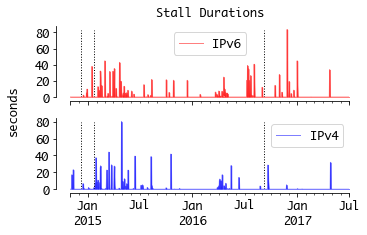

In [53]:
fig = plt.figure(figsize=(5, 3))
plt.rcParams['font.size'] = 12

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['bottom'].set_position(('axes', -0.05))
ax1.spines['left'].set_position(('axes', -0.05))

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes', -0.05))
ax2.spines['left'].set_position(('axes', -0.05))

s6 = df_.plot(  x='dtime'
             , y=['stall_total_6']
             , color=['red']
             , kind='area'
             , linewidth = 1
             , ax = ax1
             , stacked = False
            )

s4 = df_.plot(  x='dtime'
             , y=['stall_total_4']
             , color=['blue']
             , kind='area'
             , linewidth = 1
             , ax = ax2
             , stacked = False
            )

ax1.legend(['IPv6'], fontsize=12, loc='best', ncol = 3)
ax2.legend(['IPv4'], fontsize=12, loc='best', ncol = 3)
            
ax1.grid(False); ax2.grid(False)
ax1.set_xlabel('', fontsize=22)
ax2.set_xlabel('', fontsize=22)

yticks = np.arange(0,100,20)
ax1.set_yticks(yticks)
ax2.set_yticks(yticks)

ax1.yaxis.set_label_coords(-0.18, -0.2)
ax1.set_ylabel('seconds', fontsize=12)

ax1.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax1.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax1.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax1.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')

ax2.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')

fig.subplots_adjust(hspace = 0.3)

ax1.set_title('Stall Durations', fontsize=12, y=1.05)
plt.savefig('youtube-stall-durations-timeseries.pdf', format='pdf', bbox_inches='tight')